# Method comparisons for inference

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, precision_recall_curve

In [136]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver', 'black'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [137]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
import memento
import memento.simulate as simulate

In [138]:
import matplotlib
matplotlib.rcParams['legend.handlelength'] = 0

In [139]:
data_path = '/data_volume/memento/simulation/inference/'

### Run memento

In [148]:
de_sim_adata = sc.read(data_path + 'means/stratified/anndata.h5ad')
de_sim_adata.obs['q'] = 0.07

memento.setup_memento(de_sim_adata, q_column='q', filter_mean_thresh=0.0001,trim_percent=0.1, shrinkage=0)
# de_sim_adata.obs['memento_size_factor'] = de_sim_adata.X.sum(axis=1).A1
memento.create_groups(de_sim_adata, label_columns=['condition'])
memento.compute_1d_moments(de_sim_adata, filter_genes=True)

meta_df = memento.get_groups(de_sim_adata)
meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=True)

treatment = meta_df[['stim']]
covariate = pd.DataFrame(np.ones((meta_df.shape[0],1)))
# covariate = meta_df[['B', 'C', 'D']]
# covariate = pd.concat([covariate, covariate*treatment.values], axis=1)

memento.ht_1d_moments(
    de_sim_adata, 
    treatment=treatment,
    covariate=covariate,
    num_boot=5000, 
    verbose=1,
    num_cpus=14,
    resample_rep=False,
    approx=True)

memento_de_result = memento.get_1d_ht_result(de_sim_adata)
memento_de_result.to_csv(data_path + 'means/stratified/memento.csv', index=False)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=14)]: Done 732 tasks      | elapsed:    2.4s
[Parallel(n_jobs=14)]: Done 2732 tasks      | elapsed:    8.5s
[Parallel(n_jobs=14)]: Done 3027 out of 3027 | elapsed:    9.4s finished


### Compare DE methods

In [149]:
de_norm_adata

View of AnnData object with n_obs × n_vars = 200 × 1362
    obs: 'group', 'condition', 'batch'
    var: 'is_null', 'treatment_effect', 'mean', 'std'
    uns: 'log1p'

In [150]:
de_norm_adata = sc.read(data_path + 'means/stratified/norm_anndata.h5ad')
result = pd.read_csv(data_path + 'means/stratified/memento.csv').set_index('gene')
edger = pd.read_csv(data_path + 'means/stratified/edger.csv', index_col=0)

genes = list(set(result.index.tolist()) & set(edger.index))
de_norm_adata = de_norm_adata[:, genes]

result = pd.concat([result.loc[genes], edger.loc[genes]], axis=1)

A_data, B_data = de_norm_adata[de_norm_adata.obs['condition'] == 'ctrl'].X, de_norm_adata[de_norm_adata.obs['condition'] == 'stim'].X
_, result['ttest'] = stats.ttest_ind(A_data, B_data, equal_var=False)
result['mwu'] = np.array([stats.ranksums(A_data[:, i], B_data[:,i])[1] for i in range(A_data.shape[1])])

result['null'] = de_norm_adata.var['is_null'].values
result['sig'] = ~result['null']
result['memento'] = result['de_pval']
result['edger'] = result['PValue']

In [151]:
result['ttest_fdr'] = memento.util._fdrcorrect(result['ttest'])
result['memento_fdr'] = memento.util._fdrcorrect(result['de_pval'])
result['mwu_fdr'] = memento.util._fdrcorrect(result['mwu'])
result['edger_fdr'] = memento.util._fdrcorrect(result['edger'])

In [152]:
thresholds = np.linspace(0.05, 0.5, 10)
tpr_dict = {}
fdr_dict = {}
fpr_dict = {}
for method in ['memento', 'ttest', 'mwu', 'edger']:
    tpr = []
    fpr = []
    fdr = []

    for thresh in thresholds:
    
        tpr.append((result.query('sig')[method] < thresh).mean())
        fdr.append(result.query('{} < {}'.format(method, thresh))['null'].mean())
        fpr.append((result.query('null')[method] < thresh).mean())
    tpr_dict[method] = tpr
    fpr_dict[method] = fpr
    fdr_dict[method] = fdr

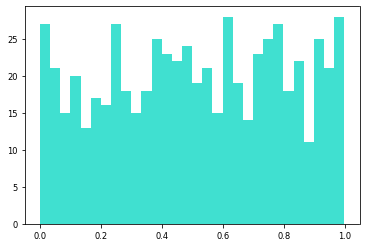

In [153]:
plt.hist(result['memento'], bins=30);

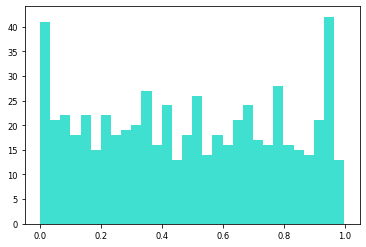

In [154]:
plt.hist(result['PValue'], bins=30);

Text(0.5, 0, 'P-value cutoff')

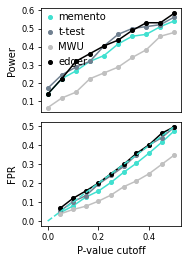

In [155]:
plt.figure(figsize=(2.5, 4))
plt.subplots_adjust(hspace=0.09)
plt.subplot(2, 1, 1)
for method in ['memento', 'ttest', 'mwu', 'edger']:
    plt.plot(thresholds, tpr_dict[method], '-o', label=method, ms=4)
plt.legend(['memento', 't-test', 'MWU', 'edger'], frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylabel('Power'); plt.xticks([])

plt.subplot(2, 1, 2)
for method in ['memento', 'ttest', 'mwu', 'edger']:
    plt.plot(thresholds, fpr_dict[method], '-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
plt.plot([0,0.5], [0, 0.5], '--')
plt.ylabel('FPR')
plt.xlabel('P-value cutoff')

# plt.savefig('de_comparison.pdf', bbox_inches='tight')

In [103]:
result.query('edger_fdr < 0.01')#.null.mean()

,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,logFC,logCPM,LR,PValue,FDR,ttest,mwu,null,sig,memento,edger,ttest_fdr,memento_fdr,mwu_fdr,edger_fdr
0,stim,1.893310,0.626239,2.581825e-03,2.696978,0.831610,0.001732,2.585658,3.306258,9.071063,2.596860e-03,8.015288e-03,7.285496e-03,0.698951,True,False,2.581825e-03,2.596860e-03,2.009418e-02,8.758337e-03,0.999907,8.036260e-03
1,stim,-0.798627,0.191830,3.138388e-05,-1.462221,0.882105,0.098476,-1.109923,5.902776,17.877800,2.355530e-05,1.196100e-04,8.968559e-05,0.122869,True,False,3.138388e-05,2.355530e-05,4.254181e-04,1.806322e-04,0.600148,1.200009e-04
7,stim,1.193903,0.206624,7.873640e-09,1.062758,0.697125,0.134422,1.760276,6.041538,42.054478,8.876568e-11,9.709249e-10,4.575603e-10,0.007405,True,False,7.873640e-09,8.876568e-11,5.202709e-09,8.297164e-08,0.065840,9.693159e-10
14,stim,0.361555,0.094658,1.337560e-04,0.616587,0.892066,0.491105,0.563156,7.626598,13.783026,2.051817e-04,8.526825e-04,1.042693e-04,0.046546,True,False,1.337560e-04,2.051817e-04,4.880463e-04,6.581895e-04,0.294899,8.556878e-04
17,stim,-0.811501,0.125049,8.809312e-11,0.174498,0.465056,0.709015,-1.137197,7.200254,50.092961,1.466321e-12,1.892625e-11,6.235338e-11,0.000045,True,False,8.809312e-11,1.466321e-12,7.744890e-10,1.164214e-09,0.000666,1.889489e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10200,stim,-0.627313,0.196094,1.384042e-03,0.196356,0.474770,0.679208,-0.831911,6.053618,10.787418,1.021923e-03,3.549039e-03,1.109979e-03,0.183238,True,False,1.384042e-03,1.021923e-03,3.958579e-03,5.107320e-03,0.780708,3.558518e-03
10205,stim,2.336292,0.603595,1.093799e-04,1.967296,0.757385,0.011637,3.161899,3.675316,17.216737,3.334853e-05,1.638241e-04,1.200457e-04,0.485923,True,False,1.093799e-04,3.334853e-05,5.534503e-04,5.487212e-04,0.999907,1.644451e-04
10210,stim,-1.572936,0.463310,7.593379e-04,0.627403,1.053528,0.572885,-2.182102,4.788712,25.589671,4.222938e-07,2.912062e-06,3.691416e-06,0.199984,True,False,7.593379e-04,4.222938e-07,2.376246e-05,3.076936e-03,0.823595,2.910005e-06
10214,stim,-1.669113,0.613521,6.944925e-03,-2.360218,0.654921,0.000336,-2.258808,3.676219,9.731452,1.811413e-03,5.866030e-03,3.947860e-03,0.640469,True,False,6.944925e-03,1.811413e-03,1.180276e-02,2.036708e-02,0.999907,5.879976e-03


In [38]:
result.query('edger_fdr < 0.05').null.mean()

0.07142857142857142

In [79]:
# plt.figure(figsize=(2.5, 2))
# for col in ['de_pval', 'ttest', 'mwu']:
    
#     fpr, tpr, t = roc_curve(result['sig'], 1-result[col])
#     plt.plot(fpr, tpr, label=col)
    
# plt.legend(['memento', 't-test', 'MWU'])
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('AUC curve (Differential mean)')
# plt.xlim(-0.01, 0.4);
# plt.ylim(-0.01, 0.6)
# plt.plot([0, 0.4], [0, 0.4], '--', color='black')